In [1]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from fbprophet import Prophet
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dask/dataframe/utils.py:15: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
import lightgbm as lgb

In [3]:
import warnings
warnings.filterwarnings('ignore')

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.

Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools


StoreType - differentiates between 4 different store models: a, b, c, d


Assortment - describes an assortment level: a = basic, b = extra, c = extended


CompetitionDistance - distance in meters to the nearest competitor store


CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened


Promo - indicates whether a store is running a promo on that day


Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating


Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2


PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [4]:
large = 26
med = 22
small = 18
params = {'axes.titlesize': med,
          'legend.fontsize': med,
          'figure.figsize': (med, small),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': med}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

### Data Reading

In [5]:
df_train = pd.read_csv('./data/rossmann-store-sales/train.csv',
                       parse_dates=["Date"])

df_test = pd.read_csv("./data/rossmann-store-sales/test.csv",
                      parse_dates=["Date"])

df_store = pd.read_csv("./data/rossmann-store-sales/store.csv")

In [6]:
df_train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [7]:
df_test.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


In [8]:
df_store.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [9]:
df_train.shape

(1017209, 9)

In [10]:
df_test.shape

(41088, 8)

In [11]:
df_store.shape

(1115, 10)

In [12]:
np.unique(df_train.DayOfWeek)

array([1, 2, 3, 4, 5, 6, 7])

In [13]:
np.unique(df_test.Date)

array(['2015-08-01T00:00:00.000000000', '2015-08-02T00:00:00.000000000',
       '2015-08-03T00:00:00.000000000', '2015-08-04T00:00:00.000000000',
       '2015-08-05T00:00:00.000000000', '2015-08-06T00:00:00.000000000',
       '2015-08-07T00:00:00.000000000', '2015-08-08T00:00:00.000000000',
       '2015-08-09T00:00:00.000000000', '2015-08-10T00:00:00.000000000',
       '2015-08-11T00:00:00.000000000', '2015-08-12T00:00:00.000000000',
       '2015-08-13T00:00:00.000000000', '2015-08-14T00:00:00.000000000',
       '2015-08-15T00:00:00.000000000', '2015-08-16T00:00:00.000000000',
       '2015-08-17T00:00:00.000000000', '2015-08-18T00:00:00.000000000',
       '2015-08-19T00:00:00.000000000', '2015-08-20T00:00:00.000000000',
       '2015-08-21T00:00:00.000000000', '2015-08-22T00:00:00.000000000',
       '2015-08-23T00:00:00.000000000', '2015-08-24T00:00:00.000000000',
       '2015-08-25T00:00:00.000000000', '2015-08-26T00:00:00.000000000',
       '2015-08-27T00:00:00.000000000', '2015-08-28

In [14]:
df_train['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [15]:
df_train.loc[df_train['StateHoliday'] == 0, 'StateHoliday'] = '0'

### Exploratory Analysis 

In [16]:
df_train.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [17]:
df_train['Year'] = df_train.Date.dt.year
df_train['Month'] = df_train.Date.dt.month
df_train['Day'] = df_train.Date.dt.day
df_train['WeekOfYear'] = df_train.Date.dt.weekofyear

#### Visualize covariates Open, Promo, StateHoliday, SchoolHoliday

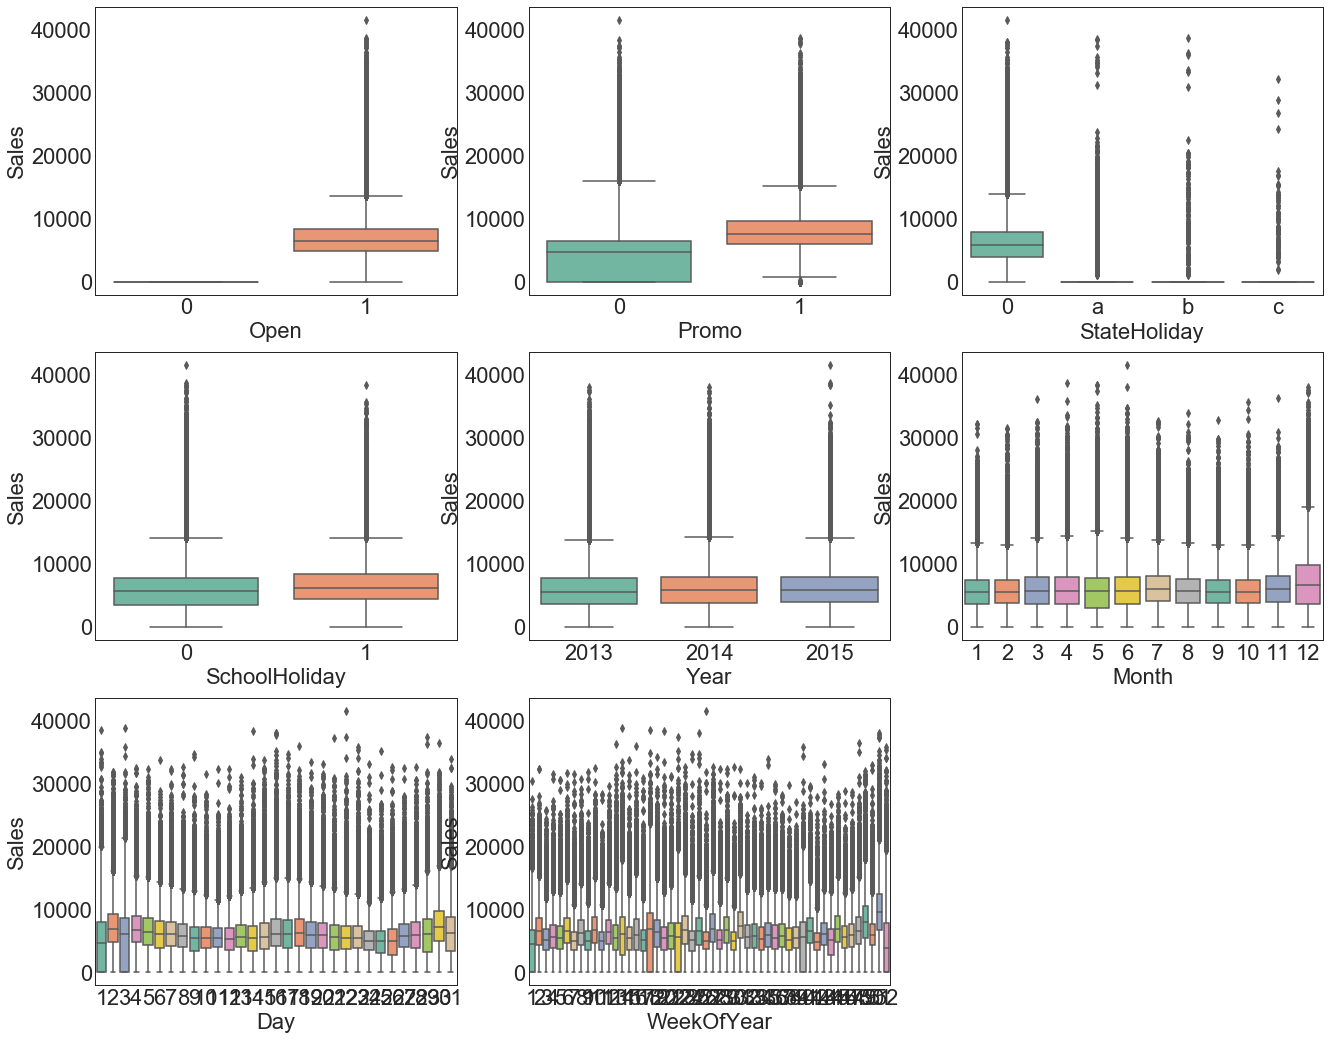

In [18]:
covariates = ['Open','Promo','StateHoliday','SchoolHoliday','Year',
             'Month','Day','WeekOfYear']

for index, c in enumerate(covariates):
    plt.subplot(3,3,index+1)
    sns.boxplot(x=c,
                y='Sales',
                data=df_train,
                palette="Set2")


#### Visualize the overall trend of the sales


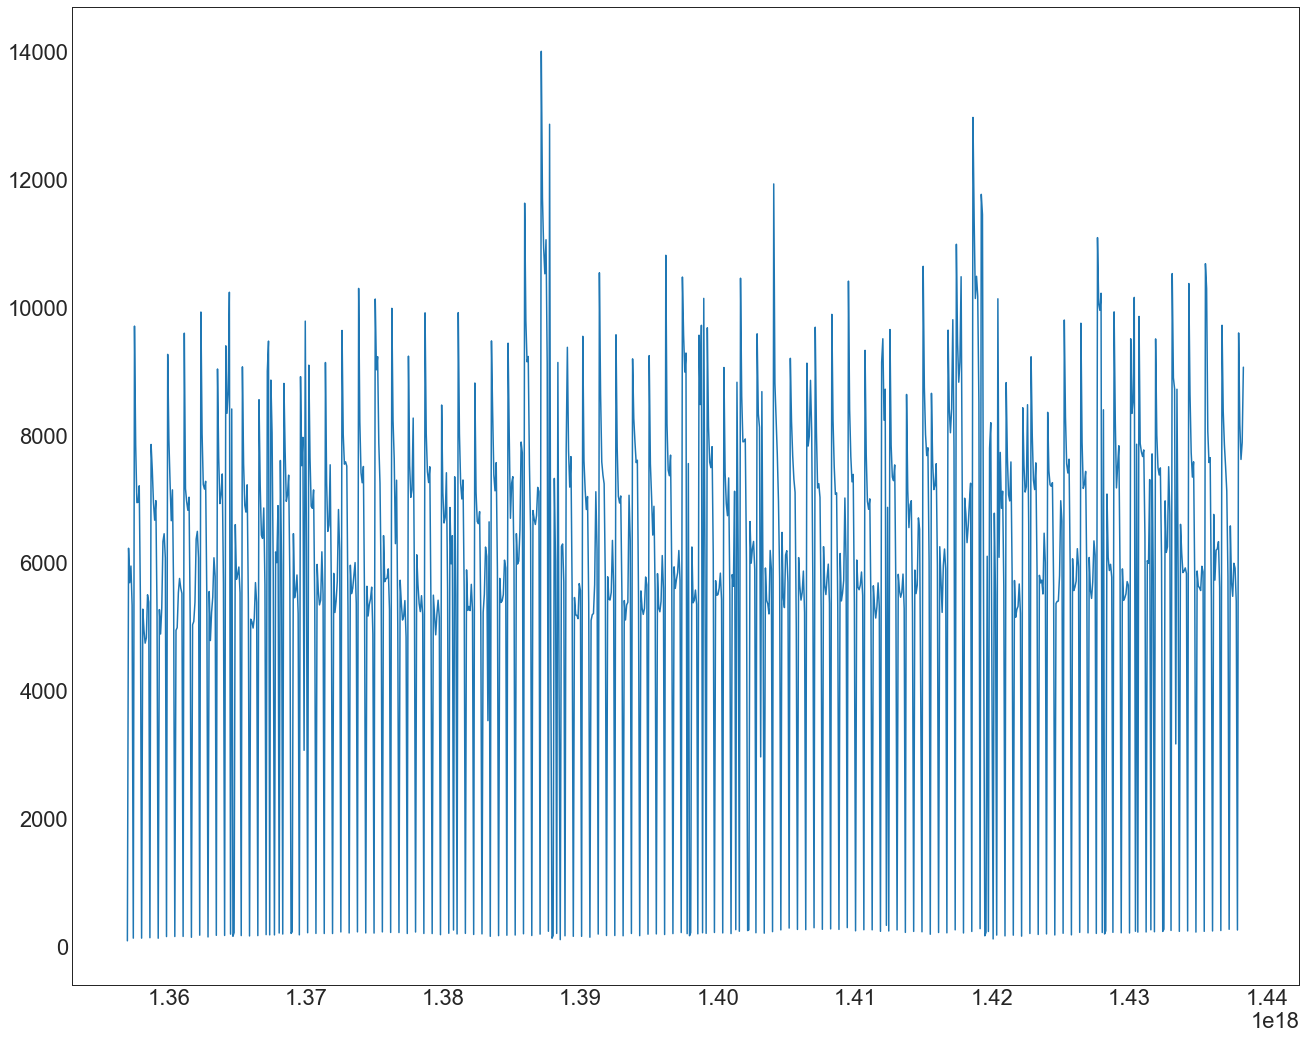

In [19]:
daily_log_sales = df_train.groupby(['Date'])['Sales'].mean().reset_index()
plt.plot('Date',
         'Sales',
         data=daily_log_sales)


### Feature Engineering

In [20]:
# Sales	Customers Open Promo StateHoliday SchoolHoliday

In [21]:
### Try to build a separate model for each date (don't use the step-by-step prediction approach)


### past 3, 7, 15, 30, 60, 90 days, for each store
    ### average sales, median sales, maximum sales 
    ### standard deviation of the these
    ### total number of promos
    ### total number of school holiday
    ### total number of state holiday
    ### what kind of holidays are there

### for each store, we also have its current status
    ### Month, Day, WeekOfYear
    ### Open Promo StateHoliday SchoolHoliday

### store level information
    ### StoreType Assortment CompetitionDistance CompetitionOpenSinceMonth (could convert) 
    ### CompetitionOpenSinceYear Promo2
    
### past 1 weeks & 4 weeks * 20 weeks -  day of the week mean sales value, total number of promotion, school holiday
### past 16 days sales
### number of days that have more than one sale

In [22]:
min(df_train['Date'])

Timestamp('2013-01-01 00:00:00')

In [23]:
max(df_train['Date'])

Timestamp('2015-07-31 00:00:00')

In [24]:
df_train_complete = pd.merge(df_train,
                             df_store,
                             how='inner',
                             left_on='Store',
                             right_on='Store')

In [25]:
df_train_complete.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [26]:
df_train_complete['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [27]:
le = LabelEncoder()
oe = OneHotEncoder(sparse=False)

In [28]:
df_train_complete['StoreType'] =  le.fit_transform(df_train_complete['StoreType'].values)
df_train_complete['Assortment'] =  le.fit_transform(df_train_complete['Assortment'].values)
df_train_complete['StateHoliday'] =  le.fit_transform(df_train_complete['StateHoliday'].values)


In [29]:
df_train_complete.shape

(1017209, 22)

In [30]:
df_train_complete['CompetitionDistance_missing'] = 0
df_train_complete.loc[df_train_complete['CompetitionDistance'].isna(), 'CompetitionDistance_missing'] = 1

In [31]:
df_train_complete['CompetitionOpen_missing'] = 0
df_train_complete.loc[df_train_complete['CompetitionOpenSinceMonth'].isna(), 'CompetitionOpen_missing'] = 1

In [32]:
df_train_complete['CompetitionDistance'] = df_train_complete['CompetitionDistance'].fillna(0)

In [33]:
df_train_complete['Competition_open_till_now_in_months'] = \
    (12 * df_train_complete['Year'] + df_train_complete['Month'] - 
    12 * df_train_complete['CompetitionOpenSinceYear'] - df_train_complete['CompetitionOpenSinceMonth'])

df_train_complete['Competition_open_till_now_in_months'] = \
    df_train_complete['Competition_open_till_now_in_months'].fillna(0)

In [34]:
df_train_complete['Promo2_till_now_in_weeks'] = \
    (54 * df_train_complete['Year'] + df_train_complete['WeekOfYear'] - 
     54 * df_train_complete['Promo2SinceYear'] - df_train_complete['Promo2SinceWeek'])   

df_train_complete['Promo2_till_now_in_weeks'] = df_train_complete['Promo2_till_now_in_weeks'].fillna(0)

In [35]:
list(df_train_complete)

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Year',
 'Month',
 'Day',
 'WeekOfYear',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'CompetitionDistance_missing',
 'CompetitionOpen_missing',
 'Competition_open_till_now_in_months',
 'Promo2_till_now_in_weeks']

In [36]:
df_train_complete.isna().sum(axis=0)

Store                                       0
DayOfWeek                                   0
Date                                        0
Sales                                       0
Customers                                   0
Open                                        0
Promo                                       0
StateHoliday                                0
SchoolHoliday                               0
Year                                        0
Month                                       0
Day                                         0
WeekOfYear                                  0
StoreType                                   0
Assortment                                  0
CompetitionDistance                         0
CompetitionOpenSinceMonth              323348
CompetitionOpenSinceYear               323348
Promo2                                      0
Promo2SinceWeek                        508031
Promo2SinceYear                        508031
PromoInterval                     

### Model Prediction

In [37]:
training_validation_time_range = {'training_1':['2013-06-01','2015-06-14'], 'val_1':['2015-06-15','2015-07-31'],
                                  'training_2':['2013-06-01','2015-04-30'], 'val_2':['2015-05-01','2015-06-15'],
                                  'training_3':['2013-06-01','2015-03-14'], 'val_3':['2015-03-15','2015-05-01'],
                                  'training_4':['2013-06-01','2015-01-31'], 'val_4':['2015-02-01','2015-03-15'],
                                  'training_5':['2013-06-01','2014-12-14'], 'val_5':['2014-12-15','2015-02-01']}

#### Baseline, just impute the latest value for each store

In [177]:
covariates = ['Store','Sales','Date']
val_errors = []
training_errors = []
df_baseline = df_train_complete[covariates]
df_baseline = df_baseline.loc[df_baseline['Sales'] > 0, :]
df_baseline = df_baseline.sort_values(by=['Store','Date'], ascending=True)

for i in [1,2,3,4,5]:
    training_data_period = training_validation_time_range['training_{}'.format(i)]
    valid_data_period = training_validation_time_range['val_{}'.format(i)]
        
    df_baseline_train = df_baseline.loc[(df_baseline['Date'] >= training_data_period[0]) & (df_baseline['Date'] <= training_data_period[1]), :]
    df_baseline_val = df_baseline.loc[(df_baseline['Date'] >= valid_data_period[0]) & (df_baseline['Date'] <= valid_data_period[1]), :]
    
    df_baseline_val_true_y = df_baseline_val['Sales'].values
    df_baseline_val = df_baseline_val.drop(columns=['Sales'])
    
    
    df_train_last_value = df_baseline_train.groupby(['Store']).tail(1).reset_index(drop=True)
    
    df_baseline_val_y = \
        pd.merge(df_baseline_val, 
                 df_train_last_value,
                 how='left',
                 left_on='Store',
                 right_on='Store')['Sales'].values
    
    val_errors.append(rmspe(df_baseline_val_true_y, df_baseline_val_y))
#     val_errors.append(mean_squared_error(df_baseline_val_true_y, df_baseline_val_y, squared=False))
    

In [178]:
np.mean(val_errors)

0.44857512703068847

In [179]:
del df_baseline_train, df_baseline_val, df_baseline

In [180]:
del df_baseline_val_true_y, df_baseline_val_y

#### Lasso Regression

In [168]:
alphas = np.linspace(0, 2, num=10)
covariates = ['DayOfWeek','Open','Promo','StateHoliday',
              'SchoolHoliday','Year','WeekOfYear',
              'StoreType','Assortment','CompetitionDistance','Promo2',
              'CompetitionDistance_missing','CompetitionOpen_missing',
              'Competition_open_till_now_in_months','Promo2_till_now_in_weeks',
              'Date','Sales']        

In [169]:
# df_train_complete['Store'] = df_train_complete['Store'].astype('category')
df_train_complete['DayOfWeek'] = df_train_complete['DayOfWeek'].astype('category')
df_train_complete['StateHoliday'] = df_train_complete['StateHoliday'].astype('category')
#df_train_complete['Month'] = df_train_complete['Month'].astype('category')
#df_train_complete['Day'] = df_train_complete['Day'].astype('category')
df_train_complete['WeekOfYear'] = df_train_complete['WeekOfYear'].astype('category')
df_train_complete['StoreType'] = df_train_complete['StoreType'].astype('category')
df_train_complete['Assortment'] = df_train_complete['Assortment'].astype('category')

In [170]:
df_ols = df_train_complete[covariates]
df_ols = \
pd.get_dummies(df_ols, columns=['DayOfWeek','StateHoliday',
                                'WeekOfYear','StoreType',
                                'Assortment'], drop_first=True)

In [171]:
df_ols = df_ols.loc[df_ols['Sales'] > 0, :]

In [172]:
val_errors_RMSPE = []
training_errors_RMSPE = []


for alpha in alphas:
    train_error = []
    val_error = []
    clf = linear_model.Lasso(alpha=alpha)
    # 5 cross validation
    for i in [1,2,3,4,5]:
        print(i)
        training_data_period = training_validation_time_range['training_{}'.format(i)]
        valid_data_period = training_validation_time_range['val_{}'.format(i)]
        
        df_ols_train = df_ols.loc[(df_ols['Date'] >= training_data_period[0]) & (df_ols['Date'] <= training_data_period[1]), :]
        df_ols_val = df_ols.loc[(df_ols['Date'] >= valid_data_period[0]) & (df_ols['Date'] <= valid_data_period[1]), :]
        
        df_ols_train_x = df_ols_train.drop(columns=['Date', 'Sales'])
        df_ols_train_y = np.log1p(df_ols_train['Sales'].values)
        
        print(df_ols_train_x.shape)
        
        df_ols_val_x = df_ols_val.drop(columns=['Date', 'Sales'])
        df_ols_val_y = np.log1p(df_ols_val['Sales'].values)
        
        clf.fit(df_ols_train_x, df_ols_train_y)
        
        
        y_val_pred = clf.predict(df_ols_val_x)
        y_training_pred = clf.predict(df_ols_train_x)
        
        y_training_pred[df_ols_train_x['Open'] == 0] = 0
        y_val_pred[df_ols_val_x['Open'] == 0] = 0
        
        val_error.append(rmspe(df_ols_val['Sales'].values, np.expm1(y_val_pred)))
        train_error.append(rmspe(df_ols_train['Sales'].values, np.expm1(y_training_pred)))
        

        
    print(np.mean(val_error))
    val_errors_RMSPE.append(np.mean(val_error))
    training_errors_RMSPE.append(np.mean(train_error))
        
        

1
(660971, 75)
2
(622333, 75)
3
(579715, 75)
4
(539557, 75)
5
(498554, 75)
0.433344837748051
1
(660971, 75)
2
(622333, 75)
3
(579715, 75)
4
(539557, 75)
5
(498554, 75)
0.5078303931946396
1
(660971, 75)
2
(622333, 75)
3
(579715, 75)
4
(539557, 75)
5
(498554, 75)
0.5087908828784424
1
(660971, 75)
2
(622333, 75)
3
(579715, 75)
4
(539557, 75)
5
(498554, 75)
0.5093787330781951
1
(660971, 75)
2
(622333, 75)
3
(579715, 75)
4
(539557, 75)
5
(498554, 75)
0.5100006149657581
1
(660971, 75)
2
(622333, 75)
3
(579715, 75)
4
(539557, 75)
5
(498554, 75)
0.5106568513069377
1
(660971, 75)
2
(622333, 75)
3
(579715, 75)
4
(539557, 75)
5
(498554, 75)
0.5113477629818787
1
(660971, 75)
2
(622333, 75)
3
(579715, 75)
4
(539557, 75)
5
(498554, 75)
0.51207366887562
1
(660971, 75)
2
(622333, 75)
3
(579715, 75)
4
(539557, 75)
5
(498554, 75)
0.5128348857710299
1
(660971, 75)
2
(622333, 75)
3
(579715, 75)
4
(539557, 75)
5
(498554, 75)
0.5134454054480359


In [181]:
val_errors_RMSPE

[0.433344837748051,
 0.5078303931946396,
 0.5087908828784424,
 0.5093787330781951,
 0.5100006149657581,
 0.5106568513069377,
 0.5113477629818787,
 0.51207366887562,
 0.5128348857710299,
 0.5134454054480359]

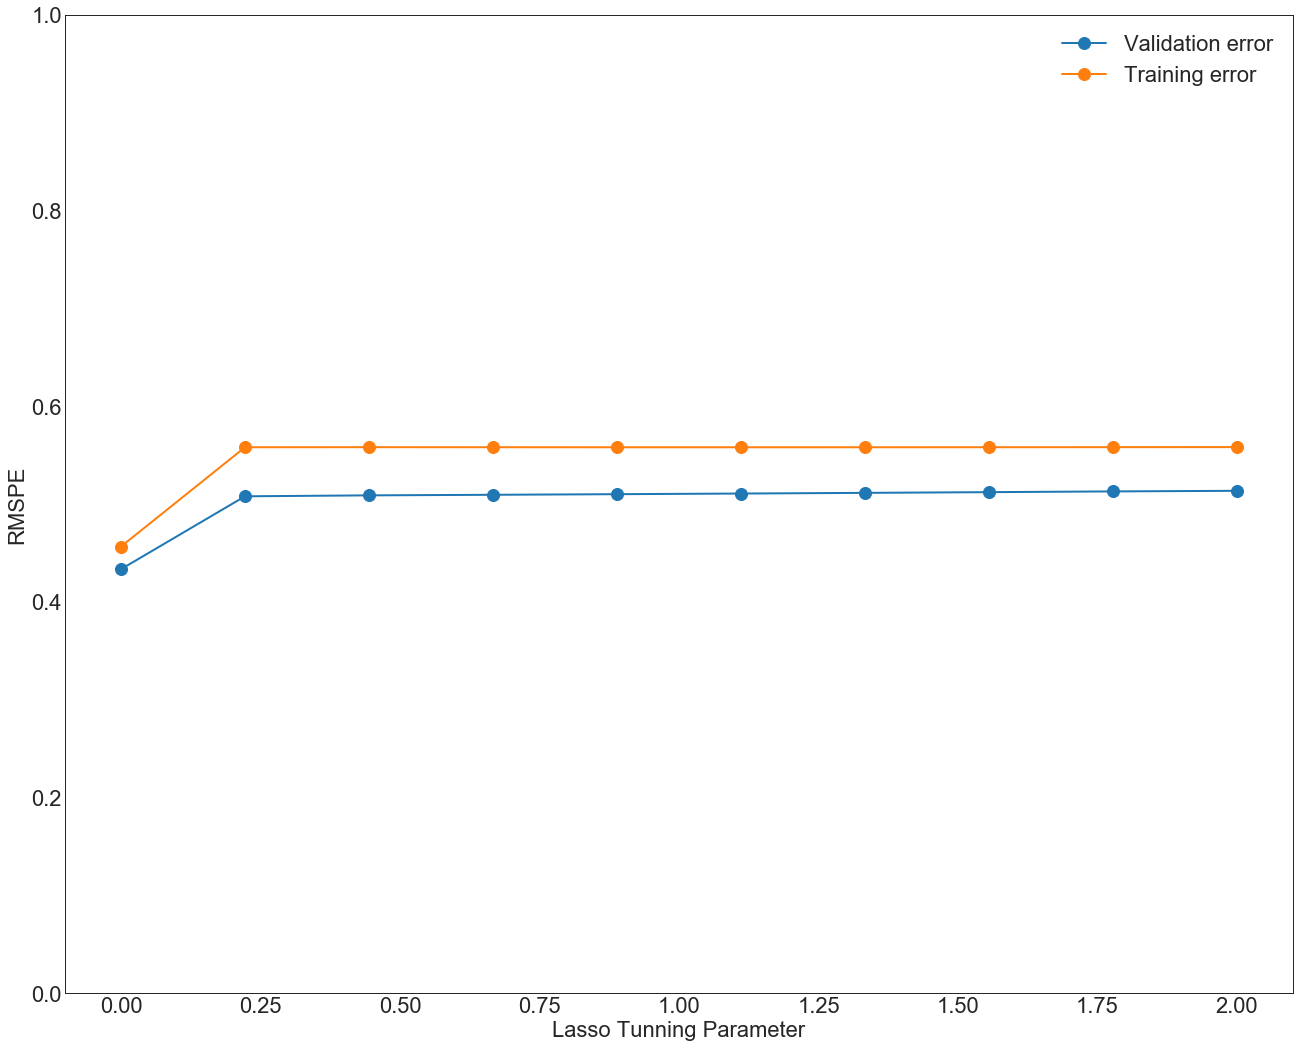

In [173]:
plt.plot(alphas, val_errors_RMSPE, 'o-', linewidth=2, markersize=12, label='Validation error',)
plt.plot(alphas, training_errors_RMSPE, 'o-', linewidth=2, markersize=12, label='Training error')
plt.xlabel("Lasso Tunning Parameter")
plt.ylabel("RMSPE")
plt.ylim(0,1)
plt.legend()

In [174]:
del df_ols_train, df_ols_val, df_ols_train_x, df_ols_train_y, df_ols_val_x, df_ols_val_y

In [175]:
del df_ols

#### Prophet

#### xgboost

In [283]:
features = ['DayOfWeek','Open','Promo','StateHoliday',
            'SchoolHoliday','Year','WeekOfYear','Month','Day',
            'StoreType','Assortment','CompetitionDistance','Promo2',
            'CompetitionDistance_missing','CompetitionOpen_missing',
            'Competition_open_till_now_in_months','Promo2_till_now_in_weeks',
            'Date','Sales']   

cat_features = ['DayOfWeek','StateHoliday','Month','Day','WeekOfYear','StoreType','Assortment']
con_features =[feature for feature in features if feature not in cat_features and feature not in ['Date','Sales']]

In [284]:
len(con_features)

10

In [285]:
len(cat_features)

7

In [286]:
val_errors_RMSPE = []
training_errors_RMSPE = []


In [287]:
df_train_complete['DayOfWeek'] = df_train_complete['DayOfWeek'].astype('category')
df_train_complete['StateHoliday'] = df_train_complete['StateHoliday'].astype('category')
df_train_complete['Month'] = df_train_complete['Month'].astype('category')
df_train_complete['Day'] = df_train_complete['Day'].astype('category')
df_train_complete['WeekOfYear'] = df_train_complete['WeekOfYear'].astype('category')
df_train_complete['StoreType'] = df_train_complete['StoreType'].astype('category')
df_train_complete['Assortment'] = df_train_complete['Assortment'].astype('category')

In [288]:
df_xg = df_train_complete[features]
df_xg = df_xg.loc[df_xg['Sales'] > 0, :]

In [289]:
params = {"objective": "reg:squarederror",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 200

In [290]:
val_errors_RMSPE = []
training_errors_RMSPE = []

for n in n_estimators:
    params["n_estimators"] = n
    train_error = []
    val_error = []
    
    for i in [1,2,3,4,5]:
        print(i)
        training_data_period = training_validation_time_range['training_{}'.format(i)]
        valid_data_period = training_validation_time_range['val_{}'.format(i)]

        df_xg_train = df_xg.loc[(df_xg['Date'] >= training_data_period[0]) & (df_xg['Date'] <= training_data_period[1]), :]
        df_xg_val = df_xg.loc[(df_xg['Date'] >= valid_data_period[0]) & (df_xg['Date'] <= valid_data_period[1]), :]

        df_xg_train_y = np.log1p(df_xg_train['Sales']).values  
        df_xg_val_y =  np.log1p(df_xg_val['Sales']).values

        df_xg_train_x = df_xg_train.drop(columns=['Date', 'Sales'])
        df_xg_val_x = df_xg_val.drop(columns=['Date', 'Sales'])

        df_xg_train_cat = oe.fit_transform(df_xg_train_x[cat_features])
        df_xg_val_cat = oe.transform(df_xg_val_x[cat_features])

        df_xg_train_con = df_xg_train_x[con_features].values
        df_xg_val_con = df_xg_val_x[con_features].values

        df_xg_train_x = np.concatenate((df_xg_train_cat, df_xg_train_con), axis=1)
        df_xg_val_x = np.concatenate((df_xg_val_cat, df_xg_val_con), axis=1)

        dtrain = xgb.DMatrix(df_xg_train_x, df_xg_train_y)
        dvalid = xgb.DMatrix(df_xg_val_x, df_xg_val_y)

        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,\
                        early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=False)

        yhat_valid = gbm.predict(xgb.DMatrix(df_xg_val_x))
        yhat_training = gbm.predict(xgb.DMatrix(df_xg_train_x))

        val_error.append(rmspe(np.expm1(df_xg_val_y), np.expm1(yhat_valid)))
        train_error.append(rmspe(np.expm1(df_xg_train_y), np.expm1(yhat_training)))
        
    val_errors_RMSPE.append(np.mean(val_error))
    training_errors_RMSPE.append(np.mean(train_error))


    

1
[18:24:09] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[18:24:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:28:51] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
2
[18:28:57] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[18:28:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameter

[19:13:57] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
4
[19:14:03] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:14:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:17:28] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
5
[19:17:33] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[19:17:33] WARNING: /Users/tra

[20:02:39] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
2
[20:02:45] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:06:41] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
3
[20:06:47] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:47] WARNING: /Users/tra

KeyboardInterrupt: 

In [293]:
del df_xg_val_x
del df_xg_val_y
del df_xg_train_x
del df_xg_train_y
del df_xg_val
del df_xg
del df_xg_train
del df_xg_train_cat
del df_xg_train_con


In [294]:
del df_xg_val_cat
del df_xg_val_con

#### Lightgbm

In [38]:
features = ['DayOfWeek','Open','Promo','StateHoliday',
            'SchoolHoliday','Year','WeekOfYear','Month','Day',
            'StoreType','Assortment','CompetitionDistance','Promo2',
            'CompetitionDistance_missing','CompetitionOpen_missing',
            'Competition_open_till_now_in_months','Promo2_till_now_in_weeks',
            'Date','Sales']   

cat_features = ['DayOfWeek','StateHoliday','Month','Day','WeekOfYear','StoreType','Assortment']
con_features =[feature for feature in features if feature not in cat_features and feature not in ['Date','Sales']]

In [39]:
df_train_complete['DayOfWeek'] = df_train_complete['DayOfWeek'].astype('category')
df_train_complete['StateHoliday'] = df_train_complete['StateHoliday'].astype('category')
df_train_complete['Month'] = df_train_complete['Month'].astype('category')
df_train_complete['Day'] = df_train_complete['Day'].astype('category')
df_train_complete['WeekOfYear'] = df_train_complete['WeekOfYear'].astype('category')
df_train_complete['StoreType'] = df_train_complete['StoreType'].astype('category')
df_train_complete['Assortment'] = df_train_complete['Assortment'].astype('category')

In [41]:
df_lightgtb = df_train_complete[features]
df_lightgtb = df_lightgtb.loc[df_lightgtb['Sales'] > 0, :]

In [57]:
params = {
    'num_leaves': 80,
    'objective': 'regression',
    'min_data_in_leaf': 200,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 16
}

MAX_ROUNDS = 5000

In [62]:
val_errors_RMSPE = []
training_errors_RMSPE = []

for l in np.arange(0.05, 0.5, 0.05):
    params['learning_rate'] = l
    val_error = []
    train_error = []
    for i in [1,2,3,4,5]:
        print(i)
        training_data_period = training_validation_time_range['training_{}'.format(i)]
        valid_data_period = training_validation_time_range['val_{}'.format(i)]

        df_lightgbm_train = \
            df_lightgtb.loc[(df_lightgtb['Date'] >= training_data_period[0]) & (df_lightgtb['Date'] <= training_data_period[1]), :].reset_index(drop=True)

        df_lightgbm_val = \
            df_lightgtb.loc[(df_lightgtb['Date'] >= valid_data_period[0]) & (df_lightgtb['Date'] <= valid_data_period[1]), :].reset_index(drop=True)

        df_lightgbm_train_y = np.log1p(df_lightgbm_train['Sales']).values 
        df_lightgbm_val_y =  np.log1p(df_lightgbm_val['Sales']).values

        df_lightgbm_train.drop(columns=['Date', 'Sales'], inplace=True)
        df_lightgbm_val.drop(columns=['Date', 'Sales'], inplace=True)


        dtrain = lgb.Dataset(
            df_lightgbm_train, label = df_lightgbm_train_y,
            categorical_feature=cat_features
        )

        dval = lgb.Dataset(
            df_lightgbm_val, label=df_lightgbm_val_y, 
            reference=dtrain,
            categorical_feature=cat_features)


        bst = lgb.train(
            params, dtrain, num_boost_round=MAX_ROUNDS,
            valid_sets=[dtrain, dval], early_stopping_rounds=100, verbose_eval=100
        )

        yhat_valid = bst.predict(df_lightgbm_val, num_iteration=bst.best_iteration or MAX_ROUNDS)
        yhat_training = bst.predict(df_lightgbm_train, num_iteration=bst.best_iteration or MAX_ROUNDS)

        val_error.append(rmspe(np.expm1(df_lightgbm_val_y), np.expm1(yhat_valid)))
        train_error.append(rmspe(np.expm1(df_lightgbm_train_y), np.expm1(yhat_training))) 
    
    val_errors_RMSPE.append(np.mean(val_error))
    training_errors_RMSPE.append(np.mean(train_error))
        
    

1
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.070093	valid_1's l2: 0.0745252
[200]	training's l2: 0.0451082	valid_1's l2: 0.054
[300]	training's l2: 0.0352437	valid_1's l2: 0.0461348
[400]	training's l2: 0.0304113	valid_1's l2: 0.0419457
[500]	training's l2: 0.0280556	valid_1's l2: 0.0398776
[600]	training's l2: 0.0262789	valid_1's l2: 0.0383445
[700]	training's l2: 0.0249043	valid_1's l2: 0.0373099
[800]	training's l2: 0.0239527	valid_1's l2: 0.0366064
[900]	training's l2: 0.023173	valid_1's l2: 0.0360678
[1000]	training's l2: 0.0224441	valid_1's l2: 0.0354643
[1100]	training's l2: 0.0217948	valid_1's l2: 0.0350169
[1200]	training's l2: 0.0212239	valid_1's l2: 0.0346734
[1300]	training's l2: 0.020726	valid_1's l2: 0.0342844
[1400]	training's l2: 0.0203091	valid_1's l2: 0.0340634
[1500]	training's l2: 0.0198628	valid_1's l2: 0.0337994
[1600]	training's l2: 0.0194511	valid_1's l2: 0.0335311
[1700]	training's l2: 0.0191176	valid_1's l2: 0.0333552


[100]	training's l2: 0.068569	valid_1's l2: 0.0933043
[200]	training's l2: 0.0438916	valid_1's l2: 0.0726338
[300]	training's l2: 0.0338458	valid_1's l2: 0.0639115
[400]	training's l2: 0.0290425	valid_1's l2: 0.0597104
[500]	training's l2: 0.0264577	valid_1's l2: 0.0574809
[600]	training's l2: 0.0247225	valid_1's l2: 0.0561548
[700]	training's l2: 0.0234897	valid_1's l2: 0.055261
[800]	training's l2: 0.0225412	valid_1's l2: 0.0546696
[900]	training's l2: 0.0216563	valid_1's l2: 0.054158
[1000]	training's l2: 0.0208676	valid_1's l2: 0.0535173
[1100]	training's l2: 0.0202738	valid_1's l2: 0.0530748
[1200]	training's l2: 0.0196498	valid_1's l2: 0.052745
[1300]	training's l2: 0.0191933	valid_1's l2: 0.0524963
[1400]	training's l2: 0.0188069	valid_1's l2: 0.0523499
[1500]	training's l2: 0.0184368	valid_1's l2: 0.0521041
[1600]	training's l2: 0.018017	valid_1's l2: 0.0519367
[1700]	training's l2: 0.0176909	valid_1's l2: 0.0517028
[1800]	training's l2: 0.0173775	valid_1's l2: 0.0515281
[1900]

[200]	training's l2: 0.0268764	valid_1's l2: 0.0395808
[300]	training's l2: 0.0237861	valid_1's l2: 0.0371492
[400]	training's l2: 0.022105	valid_1's l2: 0.0360434
[500]	training's l2: 0.020856	valid_1's l2: 0.0352745
[600]	training's l2: 0.0198466	valid_1's l2: 0.0346954
[700]	training's l2: 0.0190514	valid_1's l2: 0.0342055
[800]	training's l2: 0.0183863	valid_1's l2: 0.0339422
[900]	training's l2: 0.0178229	valid_1's l2: 0.0336015
[1000]	training's l2: 0.0172884	valid_1's l2: 0.0333643
[1100]	training's l2: 0.0168151	valid_1's l2: 0.033198
[1200]	training's l2: 0.0163577	valid_1's l2: 0.0330111
[1300]	training's l2: 0.0158838	valid_1's l2: 0.0328315
[1400]	training's l2: 0.0155407	valid_1's l2: 0.0327631
[1500]	training's l2: 0.0151913	valid_1's l2: 0.0326251
[1600]	training's l2: 0.0148661	valid_1's l2: 0.0324566
[1700]	training's l2: 0.0146037	valid_1's l2: 0.0323586
[1800]	training's l2: 0.014335	valid_1's l2: 0.0322606
[1900]	training's l2: 0.0140882	valid_1's l2: 0.032139
[2000

[300]	training's l2: 0.0208465	valid_1's l2: 0.0468568
[400]	training's l2: 0.0193519	valid_1's l2: 0.0461636
[500]	training's l2: 0.0182661	valid_1's l2: 0.0457686
[600]	training's l2: 0.0173547	valid_1's l2: 0.0454127
[700]	training's l2: 0.0165814	valid_1's l2: 0.0453325
[800]	training's l2: 0.0159417	valid_1's l2: 0.0450787
[900]	training's l2: 0.0154553	valid_1's l2: 0.0450851
[1000]	training's l2: 0.0149164	valid_1's l2: 0.044891
[1100]	training's l2: 0.0144862	valid_1's l2: 0.0447518
[1200]	training's l2: 0.0140459	valid_1's l2: 0.0446413
[1300]	training's l2: 0.0136292	valid_1's l2: 0.0444998
[1400]	training's l2: 0.0132848	valid_1's l2: 0.0444476
[1500]	training's l2: 0.0129825	valid_1's l2: 0.0443349
[1600]	training's l2: 0.0126697	valid_1's l2: 0.0442267
[1700]	training's l2: 0.0124529	valid_1's l2: 0.0443769
Early stopping, best iteration is:
[1634]	training's l2: 0.0125914	valid_1's l2: 0.0441974
5
Training until validation scores don't improve for 100 rounds
[100]	trainin

[300]	training's l2: 0.0212441	valid_1's l2: 0.039107
[400]	training's l2: 0.0199319	valid_1's l2: 0.0388888
[500]	training's l2: 0.0188973	valid_1's l2: 0.0386001
[600]	training's l2: 0.0178844	valid_1's l2: 0.0383458
[700]	training's l2: 0.0170199	valid_1's l2: 0.0381793
[800]	training's l2: 0.0163917	valid_1's l2: 0.0381495
[900]	training's l2: 0.0158412	valid_1's l2: 0.0380562
[1000]	training's l2: 0.0152949	valid_1's l2: 0.0379294
[1100]	training's l2: 0.0147959	valid_1's l2: 0.0378172
Early stopping, best iteration is:
[1043]	training's l2: 0.015073	valid_1's l2: 0.0376645
2
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0277583	valid_1's l2: 0.0517969
[200]	training's l2: 0.0226797	valid_1's l2: 0.0480542
[300]	training's l2: 0.0206236	valid_1's l2: 0.0473039
[400]	training's l2: 0.0192456	valid_1's l2: 0.046855
[500]	training's l2: 0.0180833	valid_1's l2: 0.0465559
[600]	training's l2: 0.0171024	valid_1's l2: 0.0463577
[700]	training's l2: 

In [63]:
val_errors_RMSPE

[0.22137645604370954,
 0.22165407109711932,
 0.22388689217507074,
 0.23002694760704187,
 0.2305870003261261,
 0.24168994821077822,
 0.24518458746920144,
 0.24566965269044921,
 0.2508369460835203]

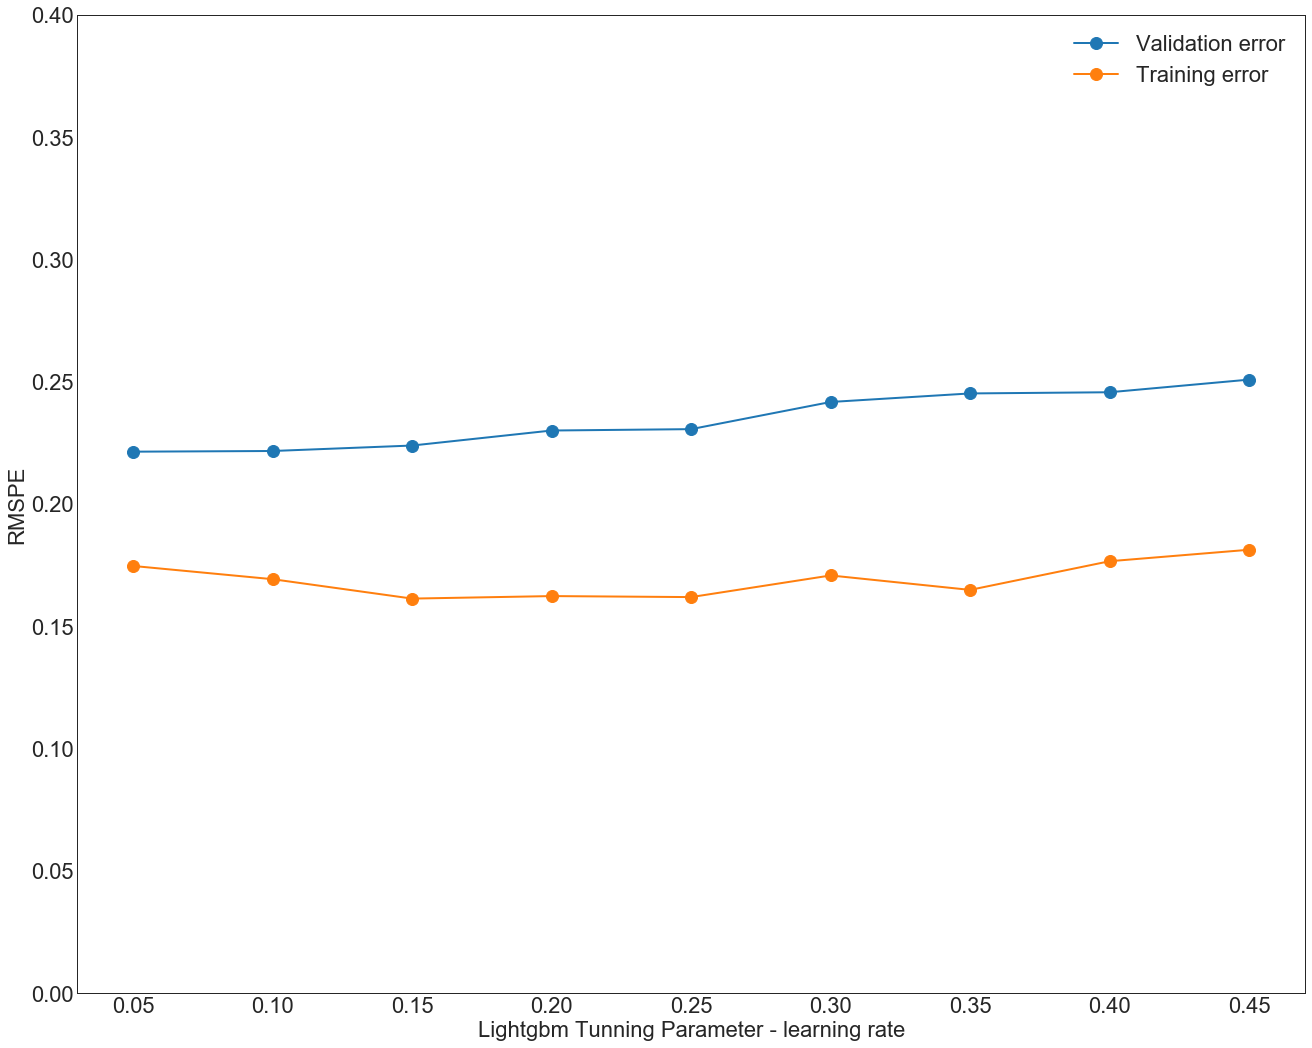

In [64]:
plt.plot(np.arange(0.05, 0.5, 0.05), val_errors_RMSPE, 'o-', linewidth=2, markersize=12, label='Validation error',)
plt.plot(np.arange(0.05, 0.5, 0.05), training_errors_RMSPE, 'o-', linewidth=2, markersize=12, label='Training error')
plt.xlabel("Lightgbm Tunning Parameter - learning rate")
plt.ylabel("RMSPE")
plt.ylim(0,0.4)
plt.legend()

### Helper function

In [45]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)